## Gender indicators in SG - Salary
#### This notebook compares median salaries between genders

#### Data set:

1) Median Monthly Basic and Gross Wages of Common Occupations by Sex in All Industries, June 2017
URL: [http://stats.mom.gov.sg/Pages/Occupational-Wages-Tables2017.aspx](http://stats.mom.gov.sg/Pages/Occupational-Wages-Tables2017.aspx)    


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from textwrap import wrap
import os

sns.set_style('whitegrid')

#set global plot aesthetics
rcParams['axes.titlesize'] = 18
rcParams['axes.titlepad'] = 15
rcParams['axes.labelsize'] = 14
rcParams['axes.labelpad'] = 10
rcParams["figure.titlesize"] = 18

%matplotlib inline

In [2]:
#load excel
file7 = "data/mrsd_2017Wages_table1.xlsx"

data_M = pd.read_excel(file7, sheet_name = 2, skiprows=9, usecols = np.arange(1,6), header=None, 
                         names = ['Code','Occupation','Number covered','Median monthly basic wage ($)',
                                  'Median monthly gross wage ($)'])
data_F = pd.read_excel(file7, sheet_name = 3, skiprows=9, usecols = np.arange(1,6), header=None, 
                         names = ['Code','Occupation','Number covered','Median monthly basic wage ($)',
                                  'Median monthly gross wage ($)'])

#### Data exploration and transformation

In [3]:
data_F.dtypes
data_F 


,Code,Occupation,Number covered,Median monthly basic wage ($),Median monthly gross wage ($)
0,1,MANAGERS,NaN,NaN,NaN
1,12112,Administration manager,1248.0,6000.0,6118.0
2,12220,Advertising/Public relations manager,367.0,6570.0,6700.0
3,14330,Arts and cultural centre manager (including ga...,58.0,5976.0,5996.0
4,12111,Budgeting and financial accounting manager (in...,3052.0,7400.0,7525.0
5,13231,Building and construction project manager,101.0,5500.0,5800.0
6,12212,Business development manager,635.0,7313.0,7657.0
7,13301,Chief information officer/Chief technology off...,35.0,8372.0,8372.0
8,11203,Chief operating officer/General Manager,301.0,10630.0,11150.0
9,13410,Child care services manager,91.0,5064.0,5150.0


By examining the data, we see that occupational groups (in all CAPs) have a single character in the 'Code' column, while occupations have 'Code' values with more than 1 character. Furthermore, occupations and their respective occupational groups share the same starting character. E.g. MANAGERS (Code Value = 1) and Administration Manager (Code Value 12122).

Occupational groups also have NaN values in the last 3 columns.

Use this information to create a dictionary, which allows occupations to be mapped to their respective occupational groups. 

In [4]:
# set Code values as string to facilitate subsetting by length
data_F['Code'], data_M['Code'] = [data['Code'].astype(str) for data in [data_F,data_M]]

# get only rows with occupational groups i.e. 'Code' with length 1
codetable = data_M.loc[data_M['Code'].apply(lambda x: len(x)) == 1]

# convert codetable to dictionary form for later processing of salary data
codetable =  codetable.dropna(axis=1) 
codetable.set_index(keys='Code', inplace=True)
codetable = codetable.transpose()
occupation_dict = codetable.to_dict()

import pprint
pprint.pprint(occupation_dict)


{'1': {'Occupation': 'MANAGERS'},
 '2': {'Occupation': 'PROFESSIONALS'},
 '3': {'Occupation': 'ASSOCIATE PROFESSIONALS AND TECHNICIANS'},
 '4': {'Occupation': 'CLERICAL SUPPORT WORKERS'},
 '5': {'Occupation': 'SERVICE AND SALES WORKERS'},
 '6': {'Occupation': 'AGRICULTURAL AND FISHERY WORKERS'},
 '7': {'Occupation': 'CRAFTSMEN AND RELATED TRADES WORKERS'},
 '8': {'Occupation': 'PLANT AND MACHINE OPERATORS AND ASSEMBLERS'},
 '9': {'Occupation': 'CLEANERS, LABOURERS AND RELATED WORKERS'}}


In [5]:
#get rows where 'Code' length >1
def extract_occupations(data):
    return(data[data['Code'].apply(lambda x: len(x)) > 1])

#map occupations to occupational group by using first character in occupation code as key
def get_occupationgroup(code,occupation_dict):
    return occupation_dict[code[0]]['Occupation'] 

#extract only occupation rows from data i.e. 'Code' with length > 1
salary_F, salary_M = [extract_occupations(data) for data in [data_F, data_M]]

# #add gender columns and merge female and male data 
salary_F['Gender']="Females"
salary_M['Gender']="Males"
salary = pd.concat([salary_F,salary_M],axis = 0, ignore_index=True)

#map occupations in salary data to occupational group using code dictionary
salary['Occupational Group'] = salary['Code'].apply(lambda x: get_occupationgroup(x, occupation_dict))


/anaconda2/envs/pydot_p3_2/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda2/envs/pydot_p3_2/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
salary.head()

,Code,Occupation,Number covered,Median monthly basic wage ($),Median monthly gross wage ($),Gender,Occupational Group
0,12112,Administration manager,1248.0,6000.0,6118.0,Females,MANAGERS
1,12220,Advertising/Public relations manager,367.0,6570.0,6700.0,Females,MANAGERS
2,14330,Arts and cultural centre manager (including ga...,58.0,5976.0,5996.0,Females,MANAGERS
3,12111,Budgeting and financial accounting manager (in...,3052.0,7400.0,7525.0,Females,MANAGERS
4,13231,Building and construction project manager,101.0,5500.0,5800.0,Females,MANAGERS


In [7]:
salary.groupby(by='Occupational Group').describe()

Median monthly basic wage ($)  \
                                                                   count   
Occupational Group                                                         
AGRICULTURAL AND FISHERY WORKERS                                     1.0   
ASSOCIATE PROFESSIONALS AND TECHNICIANS                             86.0   
CLEANERS, LABOURERS AND RELATED WORKERS                             51.0   
CLERICAL SUPPORT WORKERS                                            23.0   
CRAFTSMEN AND RELATED TRADES WORKERS                                28.0   
MANAGERS                                                            73.0   
PLANT AND MACHINE OPERATORS AND ASSEMBLERS                          35.0   
PROFESSIONALS                                                      150.0   
SERVICE AND SALES WORKERS                                           45.0   

                                                                              \
                                                   mean          std     min   
Occupational Group                                                             
AGRICULTURAL AND FISHERY WORKERS            1515.000000          NaN  1515.0   
ASSOCIATE PROFESSIONALS AND TECHNICIANS     3163.895349   586.861463  1812.0   
CLEANERS, LABOURERS AND RELATED WORKERS     1325.568627   217.918999  1000.0   
CLERICAL SUPPORT WORKERS                    2528.173913   529.347338  1500.0   
CRAFTSMEN AND RELATED TRADES WORKERS        2122.571429   429.767933  1450.0   
MANAGERS                                    6822.657534  1893.988217  2808.0   
PLANT AND MACHINE OPERATORS AND ASSEMBLERS  1910.542857   621.225371   987.0   
PROFESSIONALS                               5741.773333  2721.067248  2500.0   
SERVICE AND SALES WORKERS                   1739.488889   437.763304  1000.0   

                                                                               \
                                                25%     50%      75%      max   
Occupational Group                                                              
AGRICULTURAL AND FISHERY WORKERS            1515.00  1515.0  1515.00   1515.0   
ASSOCIATE PROFESSIONALS AND TECHNICIANS     2700.00  3194.5  3556.75   4844.0   
CLEANERS, LABOURERS AND RELATED WORKERS     1150.00  1273.0  1414.50   1849.0   
CLERICAL SUPPORT WORKERS                    2248.50  2400.0  2700.00   4016.0   
CRAFTSMEN AND RELATED TRADES WORKERS        1854.75  2071.5  2358.00   3150.0   
MANAGERS                                    5729.00  6842.0  7792.00  12000.0   
PLANT AND MACHINE OPERATORS AND ASSEMBLERS  1460.50  1820.0  2367.50   3900.0   
PROFESSIONALS                               4128.00  4750.0  6013.75  15750.0   
SERVICE AND SALES WORKERS                   1433.00  1697.0  2000.00   2898.0   

                                           Median monthly gross wage ($)  \
                                                                   count   
Occupational Group                                                         
AGRICULTURAL AND FISHERY WORKERS                                     1.0   
ASSOCIATE PROFESSIONALS AND TECHNICIANS                             86.0   
CLEANERS, LABOURERS AND RELATED WORKERS                             51.0   
CLERICAL SUPPORT WORKERS                                            23.0   
CRAFTSMEN AND RELATED TRADES WORKERS                                28.0   
MANAGERS                                                            73.0   
PLANT AND MACHINE OPERATORS AND ASSEMBLERS                          35.0   
PROFESSIONALS                                                      150.0   
SERVICE AND SALES WORKERS                                           45.0   

                                                          ...             \
                                                   mean   ...        75%   
Occupational Group                                        ...              
AGRICULTURAL AND FISHERY WORKERS            1646.000000

There is only 1 observation in the occupational group Agricultural and Fishery Workers. This observation can be included when plotting overall distributions of salaries (histograms) but will be meaningless for boxplots by occupational groups. Therefore, this observation will be excluded in the latter.

In [8]:
print("Number of observations: " + str(len(salary)))

Number of observations: 492


###  Plot histograms and boxplots

In [9]:
def overall_salary_distribution(data,filename):
    palette = ['#77B7D8', '#BABDC6']

    with sns.axes_style({'axes.grid' : False}):     #turn off grids
        
        # set up a 2 x 1 grid plot to show histograms for both genders
        g = sns.FacetGrid(salary, row='Gender', hue='Gender', size = 5, aspect=2, palette=palette,
                         gridspec_kws={"hspace":0.4})     
        
        #define bin widths
        bins = np.linspace(0, salary["Median monthly gross wage ($)"].max(),100)    
        
        #plot histograms, mapping to grid
        g.map(plt.hist, "Median monthly gross wage ($)", bins=bins, linewidth=.5, edgecolor="white")
        
        # adjust plot aestherics
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle('Distribution of median monthly gross wages ($) in 2017') 
        g.set_ylabels('Count')

    plt.savefig(filename, dpi=300)


/anaconda2/envs/pydot_p3_2/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


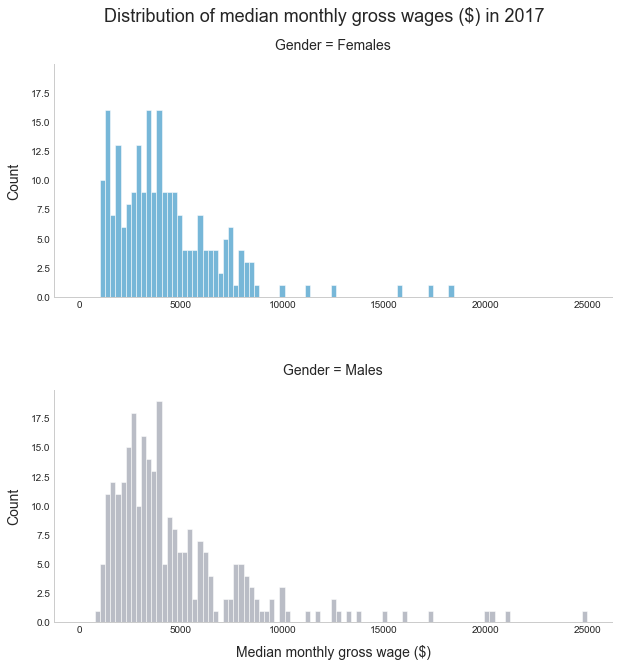

In [10]:
#create folder for saving plots        
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
createFolder('./generatedplots/')

# get histograms
filename = 'generatedplots/overall_salary_distribution.png'

overall_salary_distribution(salary, filename)

In [11]:
#exclude occupations in AGRICULTURAL AND FISHERY WORKERS for boxplots as there is only data for males and only 1 observation i.e. not suited for boxplot by occupational group
salary_reduced = salary[salary["Occupational Group"]!='AGRICULTURAL AND FISHERY WORKERS']


In [12]:
#define function to plot boxplots for each occupational group
def salary_comparison_boxplot(df, group):
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    width = 0.3
    
    sns.boxplot(x = 'Gender' , y = 'Median monthly gross wage ($)', data=df, palette="Blues",width = width,
                fliersize=0)
    
    sns.swarmplot(x = 'Gender' , y = 'Median monthly gross wage ($)', data=df, size=5, color='#505464')
    
    ax.set_title("Median salaries for {}".format(group.title()))
    
    #annotate with median values
    medians = df.groupby(by = ['Gender'])['Median monthly gross wage ($)'].median().values
    median_labels = [str(int(s)) for s in medians]

    #pos = range(len(medians))
    for i,label in enumerate(median_labels):
        ax.text(i + (width/2), medians[i] , label, 
            horizontalalignment='left', size='medium', color='black')
    
    #generate a filename 
    filename = "generatedplots/"+ group.title() + "salary_distribution.png"

    #save plot and display
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



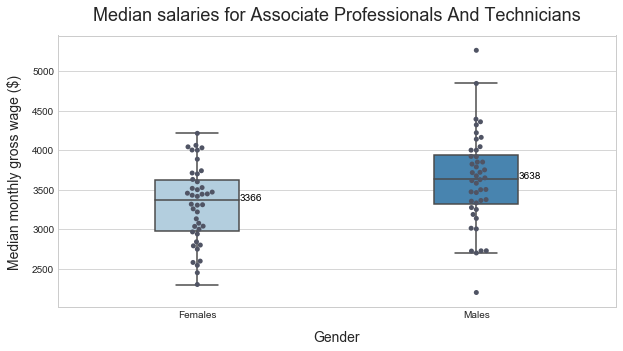

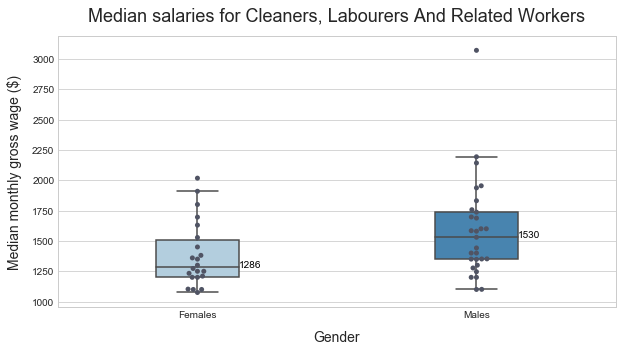

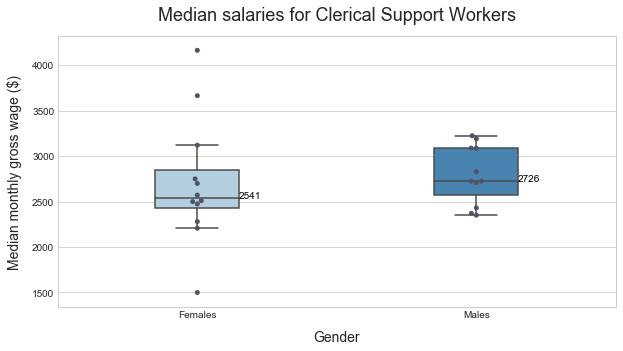

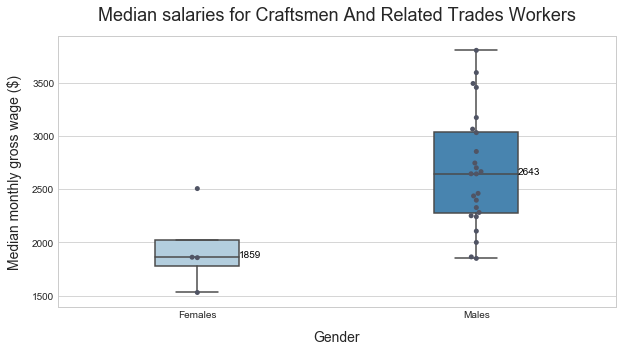

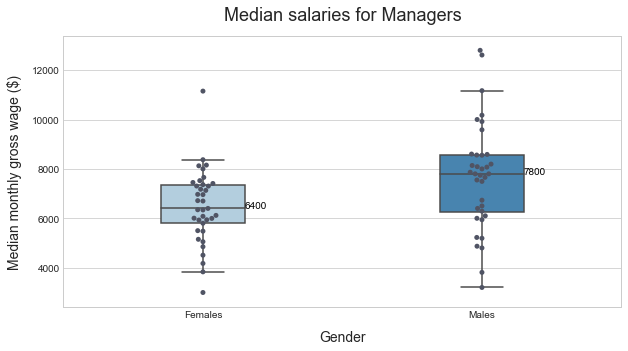

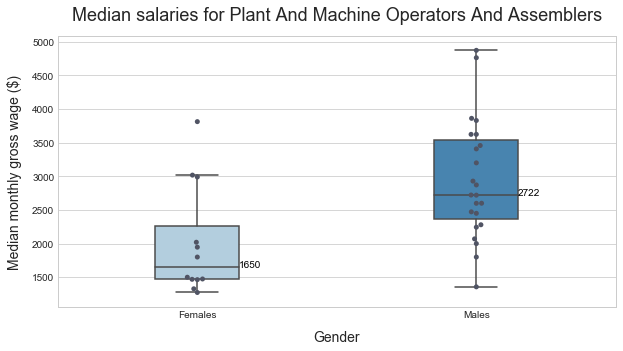

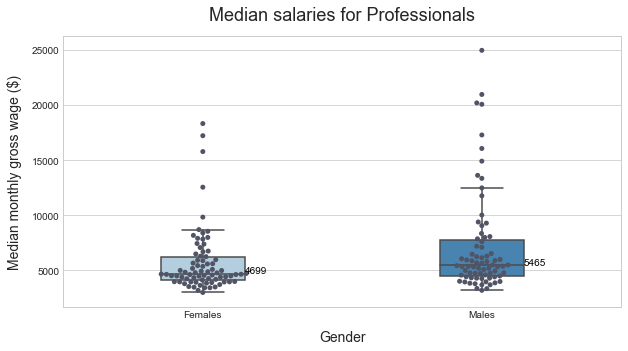

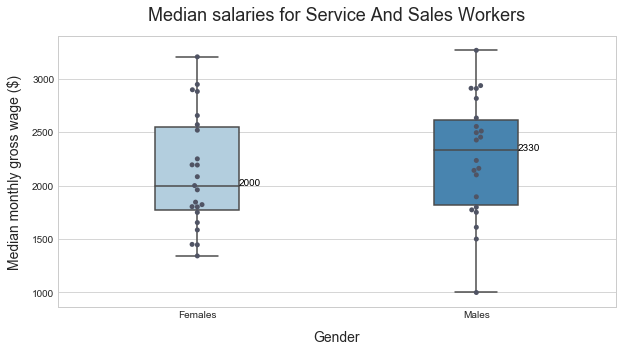

In [13]:
#get boxplots for each occupational group 
for group in np.unique(salary_reduced['Occupational Group']):  
    salary_comparison_boxplot(salary_reduced[salary_reduced['Occupational Group']==group], group) 

In [14]:
#define function to show all boxplots on 1 chart
def salary_comparison_boxplot_all(df, filename):
    
    fig, ax = plt.subplots(figsize=(10,8))
    colors = ['#77B7D8', '#929791']
    width = 0.7
    
    ylabels = ['\n'.join(wrap(var_name,30)) for var_name in df["Occupational Group"].unique()]
    
    sns.boxplot(y = 'Occupational Group' , x = 'Median monthly gross wage ($)', data=df, hue="Gender",
                palette='Blues', width=width, fliersize=1, linewidth=0.5)
    
    ax.set_title("Distribution of median gross wages ($)")
    ax.set_yticklabels([label.title() for label in ylabels])
    
    plt.savefig(filename, dpi=300, bbox_inches ='tight')
    plt.show()



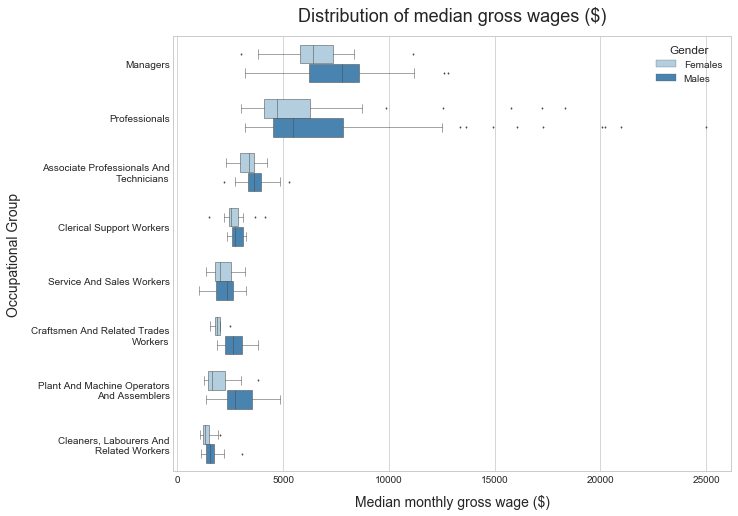

In [15]:
#get boxplot showing all groups
filename = 'generatedplots/salary_distribution_by_group.png'
salary_comparison_boxplot_all(salary_reduced, filename)

#### Store transformed salary data on SQL database

In [16]:
#create table and define schema

import mysql.connector
from mysql.connector import errorcode

user,pw, host,db = "root","sqlpace",'127.0.0.1','database1'

cnx = mysql.connector.connect(user=user, password=pw, host=host, database=db)

cursor = cnx.cursor()

query_for_creating_table = ("CREATE TABLE `salary` ("
    "`index` int(11) NOT NULL AUTO_INCREMENT,"
    "`code` varchar(10) NOT NULL,"
    "`occupation` varchar(100) NOT NULL,"
    "`number_covered` int(4) NOT NULL,"
    "`median_monthly_basic_wage` int(10) NOT NULL,"
    "`median_monthly_gross_wage` int(10) NOT NULL,"
    "`gender` varchar(20) NOT NULL,"
    "`occupational_group` varchar(100) NOT NULL,"
    "PRIMARY KEY (`index`)"
   ") ENGINE=InnoDB")

try:
   print("Executing CREATE TABLE command")
   cursor.execute(query_for_creating_table)
   cnx.commit()
   print("Table created!")

except mysql.connector.Error as err:
    if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
        print("Table already exists.")
    else:
        print(err.msg)
    exit()

finally:
  cursor.close()
  cnx.close()

Executing CREATE TABLE command
Table created!


In [17]:
#store data in table

cnx = mysql.connector.connect(user=user, password=pw, host=host, database=db)
cursor = cnx.cursor()

for index, col in salary.iterrows():
    
    data = {
        'code': col[0],
       'occupation': col[1],
       'number_covered': col[2],
       'median_monthly_basic_wage' : col[3],
       'median_monthly_gross_wage': col[4],
       'gender' : col[5], 
       'occupational_group': col[6]
     }

    query = insert_stmt = ("INSERT INTO salary (code, occupation, number_covered, median_monthly_basic_wage,median_monthly_gross_wage, gender, occupational_group)"
      "VALUES (%(code)s, %(occupation)s, %(number_covered)s, %(median_monthly_basic_wage)s, %(median_monthly_gross_wage)s, %(gender)s, %(occupational_group)s)")

    # Insert new salary data
    cursor.execute(query, data)
    print("Adding row " + str(index))
    # Make sure data is committed to the database
    cnx.commit()
    
print("All data inserted!")

cursor.close()
cnx.close()

Adding row 0
Adding row 1
Adding row 2
Adding row 3
Adding row 4
Adding row 5
Adding row 6
Adding row 7
Adding row 8
Adding row 9
Adding row 10
Adding row 11
Adding row 12
Adding row 13
Adding row 14
Adding row 15
Adding row 16
Adding row 17
Adding row 18
Adding row 19
Adding row 20
Adding row 21
Adding row 22
Adding row 23
Adding row 24
Adding row 25
Adding row 26
Adding row 27
Adding row 28
Adding row 29
Adding row 30
Adding row 31
Adding row 32
Adding row 33
Adding row 34
Adding row 35
Adding row 36
Adding row 37
Adding row 38
Adding row 39
Adding row 40
Adding row 41
Adding row 42
Adding row 43
Adding row 44
Adding row 45
Adding row 46
Adding row 47
Adding row 48
Adding row 49
Adding row 50
Adding row 51
Adding row 52
Adding row 53
Adding row 54
Adding row 55
Adding row 56
Adding row 57
Adding row 58
Adding row 59
Adding row 60
Adding row 61
Adding row 62
Adding row 63
Adding row 64
Adding row 65
Adding row 66
Adding row 67
Adding row 68
Adding row 69
Adding row 70
Adding row 71
Ad

#### Retrieve data from SQL

In [18]:
#get all data

user,pw, host,db = "root","sqlpace",'127.0.0.1','database1'

cnx = mysql.connector.connect(user=user, password=pw, host=host, database=db)

cursor = cnx.cursor()

sql ='SELECT * FROM salary '
df = pd.read_sql(sql, con=cnx)
df

,index,code,occupation,number_covered,median_monthly_basic_wage,median_monthly_gross_wage,gender,occupational_group
0,1,12112,Administration manager,1248,6000,6118,Females,MANAGERS
1,2,12220,Advertising/Public relations manager,367,6570,6700,Females,MANAGERS
2,3,14330,Arts and cultural centre manager (including ga...,58,5976,5996,Females,MANAGERS
3,4,12111,Budgeting and financial accounting manager (in...,3052,7400,7525,Females,MANAGERS
4,5,13231,Building and construction project manager,101,5500,5800,Females,MANAGERS
5,6,12212,Business development manager,635,7313,7657,Females,MANAGERS
6,7,13301,Chief information officer/Chief technology off...,35,8372,8372,Females,MANAGERS
7,8,11203,Chief operating officer/General Manager,301,10630,11150,Females,MANAGERS
8,9,13410,Child care services manager,91,5064,5150,Females,MANAGERS
9,10,12241,Customer service manager,426,5737,5930,Females,MANAGERS


In [19]:
#query subset of data

user,pw, host,db = "root","sqlpace",'127.0.0.1','database1'

cnx = mysql.connector.connect(user=user, password=pw, host=host, database=db)

cursor = cnx.cursor()

select_stmt = ("SELECT occupation, median_monthly_gross_wage, gender FROM salary WHERE occupational_group = %(occupational_group)s")
data = {'occupational_group': 'MANAGERS'} 

try:
  cursor.execute(select_stmt, data)
  df = pd.DataFrame(cursor.fetchall(), 
                    columns = ['occupation', 'median_monthly_gross_wage', 'gender'])
  print(df)
  print("Query finished!")

except mysql.connector.Error as err:
    print(err.msg)
    exit()

finally:
  cursor.close()
  cnx.close()



                                           occupation  \
0                              Administration manager   
1                Advertising/Public relations manager   
2   Arts and cultural centre manager (including ga...   
3   Budgeting and financial accounting manager (in...   
4           Building and construction project manager   
5                        Business development manager   
6   Chief information officer/Chief technology off...   
7             Chief operating officer/General Manager   
8                         Child care services manager   
9                            Customer service manager   
10         Education and training institution manager   
11  Financial/Insurance services manager (eg finan...   
12                            Health services manager   
13          Hotel operations/Lodging services manager   
14                             Human resource manager   
15                                 IT service manager   
16          Managing director/C

In [20]:
df

,occupation,median_monthly_gross_wage,gender
0,Administration manager,6118,Females
1,Advertising/Public relations manager,6700,Females
2,Arts and cultural centre manager (including ga...,5996,Females
3,Budgeting and financial accounting manager (in...,7525,Females
4,Building and construction project manager,5800,Females
5,Business development manager,7657,Females
6,Chief information officer/Chief technology off...,8372,Females
7,Chief operating officer/General Manager,11150,Females
8,Child care services manager,5150,Females
9,Customer service manager,5930,Females
